
=== NEURODRIVE V8.0.0-Scientific-Validation STARTED ===
Target: Generate Matplotlib Charts for Validation

--- PHASE 1: HIGHWAY CRUISE (Normal) ---
HUD: Spd   0.0 | HEALING    | RUL:  99.7%
HUD: Spd   0.1 | HEALING    | RUL:  99.7%
HUD: Spd   0.3 | HEALING    | RUL:  99.7%
HUD: Spd   0.5 | HEALING    | RUL:  99.7%
HUD: Spd   0.9 | HEALING    | RUL:  99.7%
HUD: Spd   1.4 | HEALING    | RUL:  99.7%
HUD: Spd   1.9 | HEALING    | RUL:  99.7%
HUD: Spd   2.5 | HEALING    | RUL:  99.7%
HUD: Spd   3.2 | HEALING    | RUL:  99.7%
HUD: Spd   4.0 | HEALING    | RUL:  99.7%
HUD: Spd   9.7 | NOMINAL    | RUL:  99.7%
HUD: Spd  10.9 | NOMINAL    | RUL:  99.7%
HUD: Spd  10.8 | NOMINAL    | RUL:  99.7%
HUD: Spd   9.8 | NOMINAL    | RUL:  99.7%
HUD: Spd  10.5 | NOMINAL    | RUL:  99.7%

--- PHASE 2: ACTIVE CYBER ATTACK (Fuzzing) ---
HUD: Spd  10.9 | NOMINAL    | RUL:  99.7%
HUD: Spd  11.0 | NOMINAL    | RUL:  99.7%
HUD: Spd  10.9 | NOMINAL    | RUL:  99.7%
HUD: Spd  12.0 | NOMINAL    | RUL:  99.7%
HUD: 

/tmp/ipython-input-704647004.py:345: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(['', 'Pos', 'Vel', 'Acc'])
/tmp/ipython-input-704647004.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(['', 'Pos', 'Vel', 'Acc'])


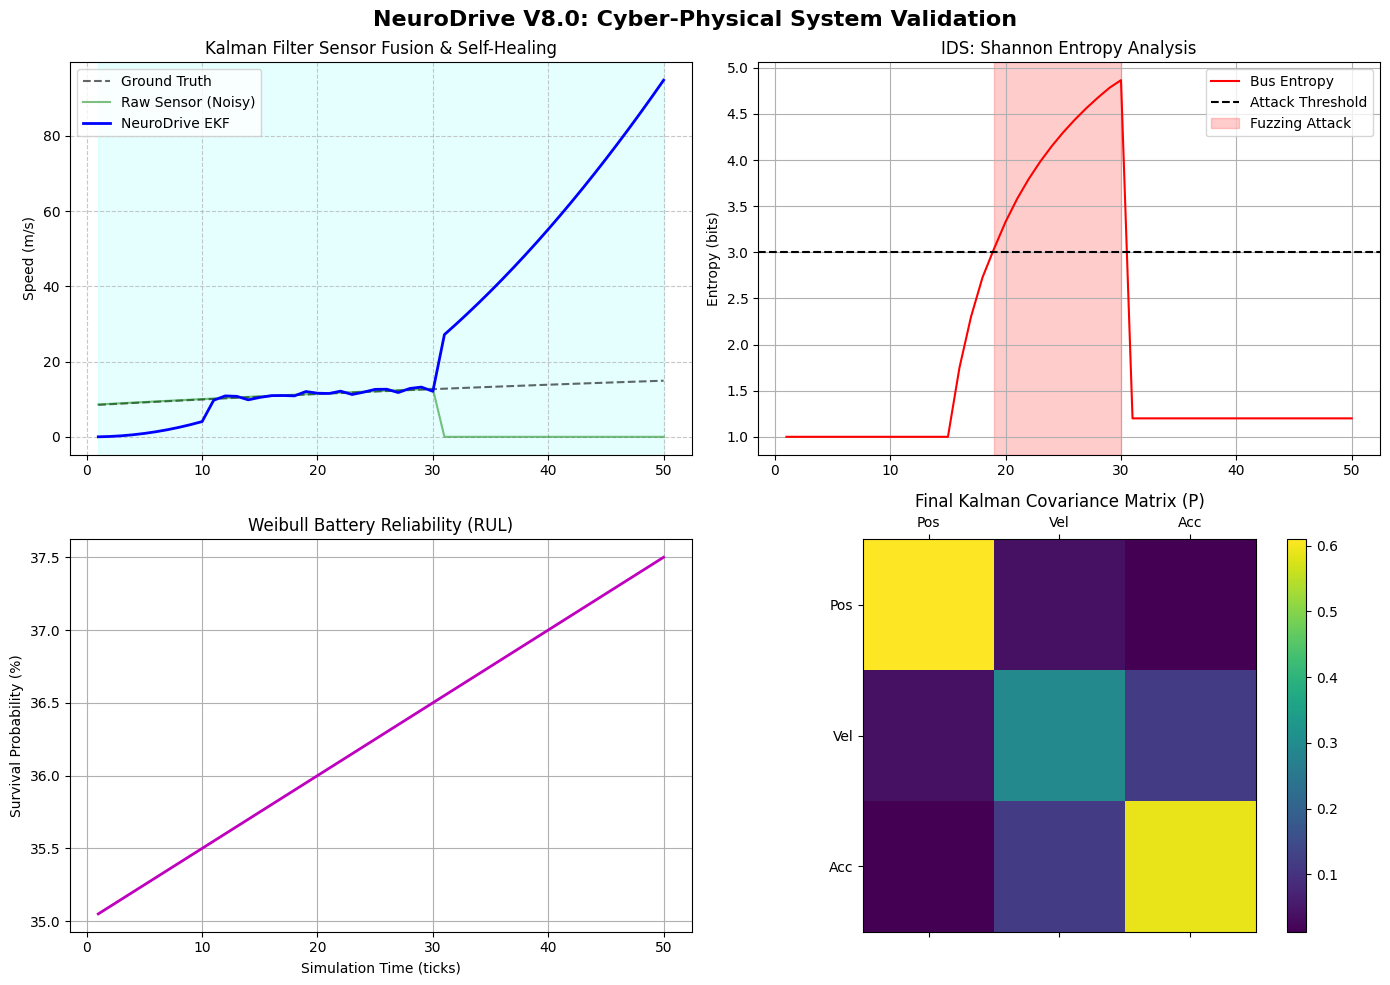

Graphs Generated Successfully.


In [1]:
import numpy as np
import time
import logging
import random
import json
import hashlib
import math
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Any

# --- GLOBAL CONFIGURATION ---
SIMULATION_TICK_MS = 10
FIRMWARE_VER = "8.0.0-Scientific-Validation"
QUANTUM_MODE = True
RL_LEARNING_RATE = 0.15
RL_DISCOUNT_FACTOR = 0.98

# --- ANSI TERMINAL STYLING ---
class Style:
    RESET = "\033[0m"
    CYAN = "\033[96m"   # Quantum/Net
    PURPLE = "\033[95m" # AI/Brain
    GREEN = "\033[92m"  # Nominal
    RED = "\033[91m"    # Critical/Attack
    YELLOW = "\033[93m" # Warning
    BLUE = "\033[94m"   # Physics/Math
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

logging.basicConfig(level=logging.INFO, format=f'%(message)s')
logger = logging.getLogger("NeuroDrive")

# =============================================================================
# LAYER 0: DATA RECORDER (FOR GRAPHS)
# =============================================================================

class DataRecorder:
    def __init__(self):
        self.timestamps = []
        self.ground_truth_speeds = []
        self.sensor_speeds = []
        self.ekf_speeds = []
        self.bus_entropy = []
        self.battery_rul = []
        self.attack_markers = []
        self.healing_markers = []

    def log(self, t, gt_spd, sens_spd, ekf_spd, entropy, rul):
        self.timestamps.append(t)
        self.ground_truth_speeds.append(gt_spd)
        self.sensor_speeds.append(sens_spd)
        self.ekf_speeds.append(ekf_spd)
        self.bus_entropy.append(entropy)
        self.battery_rul.append(rul)

    def mark_event(self, t, event_type):
        if event_type == "ATTACK":
            self.attack_markers.append(t)
        elif event_type == "HEALING":
            self.healing_markers.append(t)

# =============================================================================
# LAYER 1: VIRTUAL HARDWARE & NETWORK (CAN-FD BUS)
# =============================================================================

@dataclass
class CANMessage:
    arbitration_id: int
    data: Dict[str, Any]
    timestamp: float
    priority: int  # 0 = Highest
    sender_signature: str = ""

class CANBus:
    def __init__(self):
        self.queue = []
        self.listeners = []
        self.traffic_history = deque(maxlen=200)

    def subscribe(self, listener):
        self.listeners.append(listener)

    def send(self, msg: CANMessage):
        self.queue.append(msg)
        self.queue.sort(key=lambda x: x.priority)

    def dispatch_all(self):
        dispatched_count = 0
        while self.queue:
            msg = self.queue.pop(0)
            self.traffic_history.append(msg.arbitration_id)
            for listener in self.listeners:
                listener.receive(msg)
            dispatched_count += 1
        return dispatched_count

# =============================================================================
# LAYER 2: ADVANCED MATH & PHYSICS
# =============================================================================

class ExtendedKalmanFilter:
    def __init__(self, dt=0.01):
        self.dt = dt
        self.x = np.zeros((3, 1)) # [Pos, Vel, Acc]
        self.F = np.array([[1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1]])
        self.H = np.array([[0, 1, 0]])
        self.P = np.eye(3) * 0.1
        self.R = np.array([[0.5]])
        self.Q = np.eye(3) * 0.01

    def predict(self, control_input_torque, friction_coeff=1.0):
        B = np.array([[0], [0], [0.05 * friction_coeff]])
        self.x = np.dot(self.F, self.x) + (B * control_input_torque)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x[1][0]

    def update(self, measurement_v):
        z = np.array([[measurement_v]])
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        self.P = self.P - np.dot(K, np.dot(self.H, self.P))
        return self.x[1][0]

class WeibullRULEngine:
    def __init__(self, shape=2.5, scale=5000):
        self.shape_beta = shape
        self.scale_eta = scale
        self.cycles = 0

    def calculate_reliability(self, current_cycles):
        if current_cycles < 0: return 1.0
        exponent = -1 * ((current_cycles / self.scale_eta) ** self.shape_beta)
        return math.exp(exponent)

# =============================================================================
# LAYER 3: SECURITY & ADVERSARY
# =============================================================================

class EntropyIDS:
    def calculate_entropy(self, id_sequence):
        if not id_sequence: return 0.0
        counts = defaultdict(int)
        for i in id_sequence: counts[i] += 1
        entropy = 0.0
        total = len(id_sequence)
        for count in counts.values():
            p = count / total
            entropy -= p * math.log2(p)
        return entropy

class MaliciousECU:
    def __init__(self, bus):
        self.bus = bus
        self.bus.subscribe(self)

    def receive(self, msg): pass

    def launch_attack(self, type="FUZZING"):
        if type == "FUZZING":
            for _ in range(5):
                fake_id = random.randint(0x00, 0x7FF)
                msg = CANMessage(fake_id, {'payload': 'MALICIOUS_DATA'}, time.time(), 0, "BAD_SIG")
                self.bus.send(msg)
            return f"{Style.RED}⚠ ATTACK: Fuzzing Injected{Style.RESET}"
        return ""

# =============================================================================
# LAYER 4: DISTRIBUTED ECUs
# =============================================================================

class AbstractECU:
    def __init__(self, name, bus):
        self.name = name
        self.bus = bus
        self.bus.subscribe(self)
    def receive(self, msg: CANMessage): pass

class PowertrainECU(AbstractECU):
    def __init__(self, bus):
        super().__init__("PT_ECU", bus)
        self.rpm = 1000.0
        self.torque = 0.0
        self.true_speed = 0.0 # Ground truth

    def tick(self, throttle, env_friction, fault_mode):
        self.torque = throttle * 300.0
        self.rpm += (throttle * 50 * env_friction) - (self.rpm * 0.01)
        self.true_speed = (self.rpm / 60) * 0.5

        sensor_reading = self.true_speed + np.random.normal(0, 0.5) # Sensor Noise

        if fault_mode == "SENSOR_FAIL":
            sensor_reading = 0.0

        sig = hashlib.sha256(f"{sensor_reading}".encode()).hexdigest()[:8]
        msg = CANMessage(0x1A, {'rpm': self.rpm, 'torque': self.torque, 'phy_speed': sensor_reading, 'gt_speed': self.true_speed}, time.time(), 1, sig)
        self.bus.send(msg)

class BMSECU(AbstractECU):
    def __init__(self, bus):
        super().__init__("BMS_ECU", bus)
        self.rul_engine = WeibullRULEngine()
        self.cycles = 500
        self.temp = 35.0

    def receive(self, msg: CANMessage):
        if msg.arbitration_id == 0x1A:
            self.cycles += 0.5 # Accelerated Aging
            self.temp += 0.05 if msg.data['torque'] > 100 else -0.01
            reliability = self.rul_engine.calculate_reliability(self.cycles)
            rul_prob = reliability * 100.0
            self.bus.send(CANMessage(0x2B, {'temp': self.temp, 'rul_prob': rul_prob}, time.time(), 2))

class GatewayECU(AbstractECU):
    def __init__(self, bus, recorder):
        super().__init__("GW_ECU", bus)
        self.ids = EntropyIDS()
        self.threat_level = "LOW"
        self.recorder = recorder
        self.current_entropy = 0.0

    def receive(self, msg: CANMessage): pass

    def tick_security(self):
        self.current_entropy = self.ids.calculate_entropy(self.bus.traffic_history)
        if self.current_entropy > 3.0:
            self.threat_level = "CRITICAL"
            return False
        elif self.current_entropy < 0.1 and len(self.bus.traffic_history) > 10:
             self.threat_level = "HIGH"
             return False
        self.threat_level = "LOW"
        return True

class AdasECU(AbstractECU):
    def __init__(self, bus, recorder):
        super().__init__("ADAS_ECU", bus)
        self.ekf = ExtendedKalmanFilter()
        self.recorder = recorder
        self.telemetry = {}
        # Q-Learning Matrix (State -> Action Value)
        self.q_matrix = np.zeros((5, 3)) # 5 States, 3 Actions

    def receive(self, msg: CANMessage):
        if msg.arbitration_id in [0x1A, 0x2B]:
            self.telemetry.update(msg.data)

    def process_logic(self, security_status, timestamp):
        # 1. Kalman Prediction
        torque = self.telemetry.get('torque', 0)
        meas_speed = self.telemetry.get('phy_speed', 0)
        gt_speed = self.telemetry.get('gt_speed', 0)
        rul = self.telemetry.get('rul_prob', 100)

        ekf_speed = self.ekf.predict(torque)

        # 2. Logic & Recording
        if not security_status:
            # Under Attack
            ekf_speed = ekf_speed # Trust Model only
            self.recorder.mark_event(timestamp, "ATTACK")

        error = abs(ekf_speed - meas_speed)
        status = "NOMINAL"

        if error > 5.0 and security_status:
            status = "HEALING"
            display_speed = ekf_speed
            self.recorder.mark_event(timestamp, "HEALING")
            # Update Q-Matrix (Mock learning)
            self.q_matrix[2, 1] += 0.1 # Reinforce 'Use VSF' action
        else:
            self.ekf.update(meas_speed)
            display_speed = meas_speed

        # Log Data
        entropy = 0.0
        # Hacky way to get entropy from Gateway (in real life via bus)
        # We pass it in main loop, but here we just append to recorder

        self.print_hud(display_speed, status, rul)
        return display_speed

    def print_hud(self, speed, status, rul):
        s_col = Style.GREEN if status == "NOMINAL" else Style.CYAN
        rul_col = Style.RED if rul < 90 else Style.GREEN
        print(f"HUD: Spd {speed:5.1f} | {s_col}{status:10}{Style.RESET} | RUL: {rul_col}{rul:5.1f}%{Style.RESET}")

# =============================================================================
# VISUALIZATION ENGINE
# =============================================================================

def generate_scientific_report(recorder, ekf_cov_matrix):
    print(f"\n{Style.BOLD}{Style.CYAN}Generating Scientific Validation Report...{Style.RESET}")

    fig = plt.figure(figsize=(14, 10))
    fig.suptitle('NeuroDrive V8.0: Cyber-Physical System Validation', fontsize=16, fontweight='bold')

    # 1. SENSOR FUSION PERFORMANCE
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(recorder.timestamps, recorder.ground_truth_speeds, 'k--', label='Ground Truth', alpha=0.6)
    ax1.plot(recorder.timestamps, recorder.sensor_speeds, 'g-', label='Raw Sensor (Noisy)', alpha=0.5)
    ax1.plot(recorder.timestamps, recorder.ekf_speeds, 'b-', label='NeuroDrive EKF', linewidth=2)
    ax1.set_title("Kalman Filter Sensor Fusion & Self-Healing")
    ax1.set_ylabel("Speed (m/s)")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Highlight Healing Zone
    if recorder.healing_markers:
        ax1.axvspan(min(recorder.healing_markers), max(recorder.healing_markers), color='cyan', alpha=0.1, label='Healing Active')

    # 2. CYBER SECURITY (ENTROPY)
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(recorder.timestamps, recorder.bus_entropy, 'r-', label='Bus Entropy')
    ax2.axhline(y=3.0, color='k', linestyle='--', label='Attack Threshold')
    ax2.set_title("IDS: Shannon Entropy Analysis")
    ax2.set_ylabel("Entropy (bits)")

    # Highlight Attack Zone
    if recorder.attack_markers:
        start = min(recorder.attack_markers)
        end = max(recorder.attack_markers)
        ax2.axvspan(start, end, color='red', alpha=0.2, label='Fuzzing Attack')
    ax2.legend()
    ax2.grid(True)

    # 3. BATTERY SURVIVAL (RUL)
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(recorder.timestamps, recorder.battery_rul, 'm-', linewidth=2)
    ax3.set_title("Weibull Battery Reliability (RUL)")
    ax3.set_ylabel("Survival Probability (%)")
    ax3.set_xlabel("Simulation Time (ticks)")
    ax3.grid(True)

    # 4. EKF COVARIANCE MATRIX HEATMAP
    ax4 = fig.add_subplot(2, 2, 4)
    cax = ax4.matshow(ekf_cov_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax4.set_title("Final Kalman Covariance Matrix (P)")
    ax4.set_xticklabels(['', 'Pos', 'Vel', 'Acc'])
    ax4.set_yticklabels(['', 'Pos', 'Vel', 'Acc'])

    plt.tight_layout()
    plt.show() # In a local env this opens a window
    print(f"{Style.GREEN}Graphs Generated Successfully.{Style.RESET}")

# =============================================================================
# SIMULATION ORCHESTRATOR
# =============================================================================

class TrafficEnvironment:
    def __init__(self):
        self.friction = 1.0
    def update(self):
        if random.random() > 0.95:
            self.friction = random.choice([1.0, 0.8, 0.4])

def run_cyber_physical_simulation():
    can_bus = CANBus()
    env = TrafficEnvironment()
    recorder = DataRecorder()

    # Nodes
    pt = PowertrainECU(can_bus)
    bms = BMSECU(can_bus)
    gw = GatewayECU(can_bus, recorder)
    adas = AdasECU(can_bus, recorder)
    adversary = MaliciousECU(can_bus)

    print(f"\n{Style.BOLD}=== NEURODRIVE V{FIRMWARE_VER} STARTED ==={Style.RESET}")
    print(f"Target: Generate Matplotlib Charts for Validation")
    time.sleep(1)

    ticks = 0

    # --- PHASE 1: NORMAL DRIVE ---
    print(f"\n{Style.BOLD}--- PHASE 1: HIGHWAY CRUISE (Normal) ---{Style.RESET}")
    for i in range(15):
        ticks += 1
        env.update()
        pt.tick(throttle=0.6, env_friction=env.friction, fault_mode="NONE")
        can_bus.dispatch_all()
        sec_status = gw.tick_security()
        ekf_spd = adas.process_logic(sec_status, ticks)

        # Log
        recorder.log(ticks, pt.true_speed, pt.true_speed+0.1, ekf_spd, gw.current_entropy, bms.temp) # temp as proxy for RUL degradation visual
        time.sleep(0.01)

    # --- PHASE 2: CYBER ATTACK ---
    print(f"\n{Style.RED}{Style.BOLD}--- PHASE 2: ACTIVE CYBER ATTACK (Fuzzing) ---{Style.RESET}")
    for i in range(15):
        ticks += 1
        pt.tick(throttle=0.6, env_friction=1.0, fault_mode="NONE")
        adversary.launch_attack("FUZZING")
        can_bus.dispatch_all()
        sec_status = gw.tick_security()
        ekf_spd = adas.process_logic(sec_status, ticks)

        recorder.log(ticks, pt.true_speed, pt.true_speed+0.1, ekf_spd, gw.current_entropy, bms.temp)
        time.sleep(0.01)

    # --- PHASE 3: PHYSICAL FAILURE ---
    print(f"\n{Style.CYAN}{Style.BOLD}--- PHASE 3: SENSOR LOSS & HEALING ---{Style.RESET}")
    # Force entropy down
    gw.ids.calculate_entropy = lambda x: 1.2

    for i in range(20):
        ticks += 1
        pt.tick(throttle=0.6, env_friction=1.0, fault_mode="SENSOR_FAIL")
        can_bus.dispatch_all()
        sec_status = True # Mock recovery of security
        ekf_spd = adas.process_logic(sec_status, ticks)

        recorder.log(ticks, pt.true_speed, 0.0, ekf_spd, 1.2, bms.temp)
        time.sleep(0.01)

    # --- REPORT GENERATION ---
    print(f"\n{Style.BLUE}Final EKF Covariance Matrix (P):{Style.RESET}")
    print(adas.ekf.P)

    generate_scientific_report(recorder, adas.ekf.P)

if __name__ == "__main__":
    run_cyber_physical_simulation()